In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from tensorflow.keras.optimizers import Adam
# Import necessary modules from ncps and Keras
from ncps import wirings
from ncps.keras import LTC
from tensorflow import keras

In [42]:
CONFIG = {
    "dataset_path": "synthetic_solar_usage_dataset.csv",
    "sequence_length": 24,
    "test_size": 0.2,
    "epochs": 100,
    "batch_size": 32,
    "model_save_path": "unified_usage_lstm.keras",
    "scaler_save_path": "unified_scaler.save",
    "feature_config_path": "feature_config.json",
    "threshold": 2.0  # kW threshold for classification
}

In [43]:
def convert_numpy_types(obj):
    # If the object is a numpy scalar, convert to its Python equivalent.
    if isinstance(obj, np.generic):
        return obj.item()
    # If the object is a Python type (like int or float), return its name as a string.
    elif isinstance(obj, type):
        return obj.__name__
    # Recursively handle dictionaries.
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    # Recursively handle lists.
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    # Otherwise return the object as-is.
    return obj

# Example usage:
feature_config = {
    'numeric_features': ['hour', 'day_of_week', 'month', 'temperature', 'cloud_cover', 'humidity'],
    'categorical_features': {
        'consumer_type': {'Residential': 0, 'Business': 1},
        'day_type_columns': ['day_Weekday', 'day_Weekend', 'day_Holiday']
    },
    'dtype_mappings': {
        'hour': int,
        'day_of_week': int,
        'month': int,
        'temperature': float,
        'cloud_cover': int,
        'humidity': int
    }
}

# Convert and save the configuration to JSON
with open('feature_config.json', 'w') as f:
    json.dump(convert_numpy_types(feature_config), f, indent=2)

In [44]:
def load_and_preprocess_data():
    df = pd.read_csv(CONFIG['dataset_path'], parse_dates=['timestamp'])
    # Drop columns with >50% NaNs (e.g., 35k NaNs in 70k rows)
    cols_to_drop = [
        'water_heating_kW', 'cooking_kW', 'entertainment_kW',
        'laundry_kW', 'ev_charging_kW', 'equipment_kW', 'production_kW'
    ]
    df = df.drop(columns=cols_to_drop)
    
    # Time-series columns: Forward-fill + Backfill
    time_cols = ['total_consumption_kW', 'solar_generation_kW', 'temperature', 'cloud_cover']
    df[time_cols] = df[time_cols].fillna(method='ffill').fillna(method='bfill')

    # Categorical columns: Add "Unknown" category
    df['day_type'] = df['day_type'].fillna('Unknown')

    # Intermittent NaNs: Hybrid imputation
    remaining_cols = ['hvac_kW', 'lighting_kW', 'panel_efficiency', 'self_consumption_ratio']
    df[remaining_cols] = df[remaining_cols].fillna(df[remaining_cols].median())


    df = pd.get_dummies(df, columns=['day_type'], prefix='day')
    # Forward-fill for time-series data
    df.fillna(method='ffill', inplace=True)

    # Verify no remaining NaNs
    assert not df.isna().any().any(), "NaNs still present after full cleanup"


    # lee = LabelEncoder()
    # df['day_type'] = lee.fit_transform(df['day_type'].astype(str))

    # Feature engineering and encoding
    le = LabelEncoder()
    df['consumer_type'] = le.fit_transform(df['consumer_type'])
    
    # Create feature config with native Python types
    feature_config = {
        'numeric_features': [col for col in df.select_dtypes(include=[np.number]).columns if col != 'total_consumption_kW'],
        'categorical_features': {
            'consumer_type': dict(zip(map(str, ['Residential', 'Business']), [0, 1])),
            'day_type_columns': [col for col in df.columns if col.startswith('day_')]
        },
        'dtype_mappings': {
            'hour': int,
            'day_of_week': int,
            'month': int,
            'temperature': float,
            'cloud_cover': int,
            'humidity': int
        }
    }
    
    # Save feature_config with proper type conversion
    with open('feature_config.json', 'w') as f:
        json.dump(convert_numpy_types(feature_config), f, indent=2)
    
    return df


In [45]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :-1])
        y.append(data[i + seq_length - 1, -1])
    return np.array(X), np.array(y)


In [ ]:
def lnn_model():
    ncp_arch = wirings.AutoNCP(8, 1) # 8 input units and 1 output unit

    # Create a sequential model using Keras
    ncp_model = keras.models.Sequential(
        [
            # Input layer expects sequences of length None (variable length) with 2 features
            keras.layers.InputLayer(input_shape=(None, 2)),
            
            # Add the LTC layer with the previously defined architecture
            # The layer is set to return sequences, making it suitable for time series tasks
            LTC(ncp_arch, return_sequences=True),
        ]
    )

    # Compile the model with the Adam optimizer and mean squared error loss function
    ncp_model.compile(
        optimizer=keras.optimizers.Adam(0.01),  # Learning rate set to 0.01
        loss='mean_squared_error'  # Common loss function for regression tasks
    )

    # Display the model's summary, which provides an overview of the architecture and parameters
    ncp_model.summary()

In [48]:

def build_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    optimizer = Adam(
        learning_rate=0.001,
        clipnorm=1.0,  # Clip gradients by norm
    )
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


C:\Users\barga\AppData\Local\Temp\ipykernel_7904\2015591926.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[time_cols] = df[time_cols].fillna(method='ffill').fillna(method='bfill')
C:\Users\barga\AppData\Local\Temp\ipykernel_7904\2015591926.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Epoch 1/100


c:\Users\barga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1405/1405 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.9309 - mae: 0.4671 - val_loss: 0.3128 - val_mae: 0.3088
Epoch 2/100
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.1854 - mae: 0.2231 - val_loss: 0.2905 - val_mae: 0.2680
Epoch 3/100
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 0.1533 - mae: 0.1888 - val_loss: 0.3884 - val_mae: 0.3383
Epoch 4/100
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.1529 - mae: 0.1787 - val_loss: 0.2842 - val_mae: 0.2481
Epoch 5/100
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.1385 - mae: 0.1681 - val_loss: 0.2744 - val_mae: 0.2431
Epoch 6/100
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.1475 - mae: 0.1660 - val_loss: 0.2782 - val_mae: 0.2313
Epoch 7/100
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.1183 - mae: 0.1527 - val_loss: 0.2641 - val_mae: 0.2218
Epoch 8/100
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.1275 - mae: 0.1564 - val_loss: 0.3098 - val_mae: 0.2717
Epoch 9/100
1405/1405 ━━━━━━

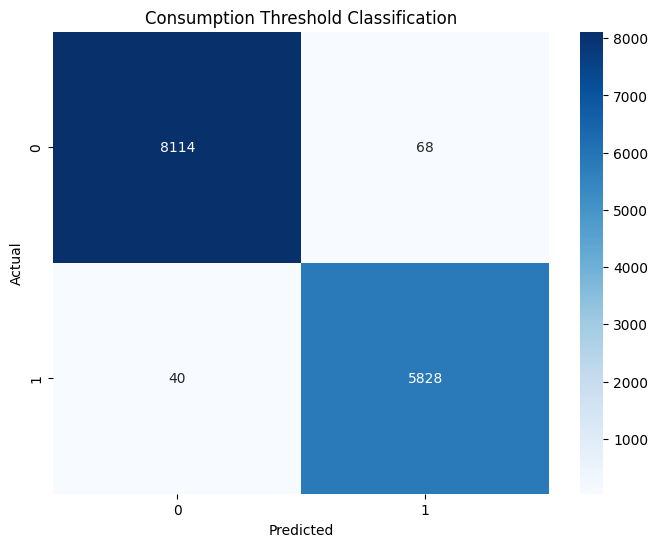

In [49]:
def main():
    # Load and preprocess data
    df = load_and_preprocess_data()
    
    # Select features and target
    features = df.drop(columns=['timestamp', 'total_consumption_kW'])
    target = df['total_consumption_kW'].values
    
    # Scale features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    scaled_data = np.column_stack((scaled_features, target))
    
    # Create sequences
    X, y = create_sequences(scaled_data, CONFIG['sequence_length'])

    # Check for NaNs/Infs in training data

    # Train-test split
    split = int(len(X) * (1 - CONFIG['test_size']))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    assert not np.isnan(X_train).any(), "X_train contains NaNs"
    assert not np.isinf(X_train).any(), "X_train contains Infs"
    assert np.isfinite(y_train).all(), "y_train contains invalid values"
    
    # Build model
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    
    # Train model
    checkpoint = ModelCheckpoint(
        CONFIG['model_save_path'], 
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=CONFIG['epochs'],
        batch_size=CONFIG['batch_size'],
        validation_split=0.2,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            checkpoint
        ]
    )
    
    # Evaluate
    y_pred = model.predict(X_test).flatten()
    
    # Regression metrics
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    
    # Classification metrics (using threshold)
    y_test_class = (y_test > CONFIG['threshold']).astype(int)
    y_pred_class = (y_pred > CONFIG['threshold']).astype(int)
    
    print(f"Accuracy: {accuracy_score(y_test_class, y_pred_class):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_class, y_pred_class))
    
    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test_class, y_pred_class), 
                annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Consumption Threshold Classification')
    plt.show()
    
    # Save scaler
    joblib.dump(scaler, CONFIG['scaler_save_path'])

if __name__ == "__main__":
    main()
